In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # This should return True if CUDA is available


2.3.1+cpu
False


In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import json
import os
import collections

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import itertools
from itertools import combinations 


import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 

from sklearn import metrics
 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch_geometric.data import Data
from torch_geometric.data import DataLoader as DataLoaderGraph
from torch_geometric.data import Dataset as DatasetGraph
from torch_geometric.data import Batch as BatchGraph
#from torch_geometric.transforms import AddTrainValTestMask as masking

from torch_geometric.nn import GCNConv, BatchNorm, SAGEConv, SGConv, ChebConv
from torch_geometric.utils.convert import to_networkx

import networkx as nx

In [4]:
with open("C:/Users/satvi/OneDrive/Desktop/proj1-SNA-using-GNN/dataset/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)

edges=pd.read_csv("C:/Users/satvi/OneDrive/Desktop/proj1-SNA-using-GNN/dataset/musae_git_edges.csv")
target_df=pd.read_csv("C:/Users/satvi/OneDrive/Desktop/proj1-SNA-using-GNN/dataset/musae_git_target.csv")#.to_numpy()[:,2]

In [6]:
print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [7]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]

print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


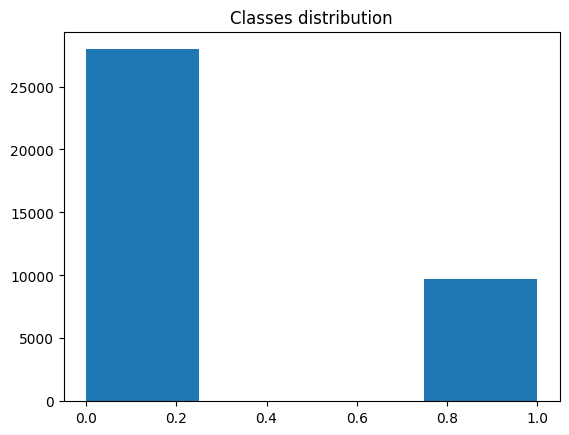

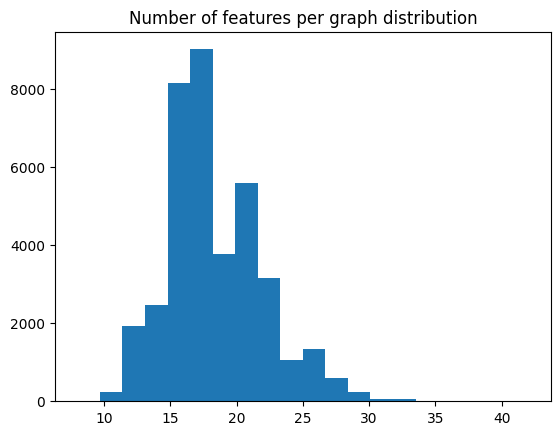

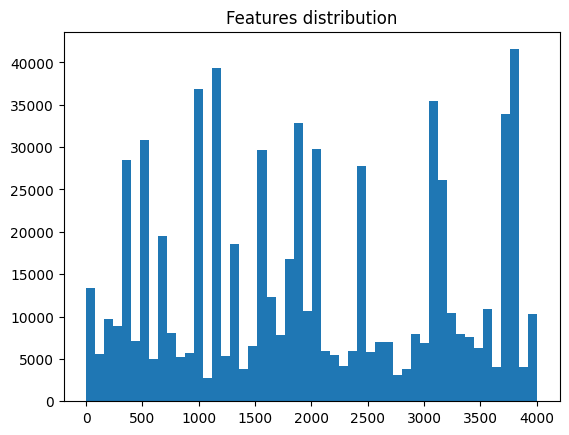

In [8]:
plt.hist(target_df.ml_target,bins=4,);
plt.title("Classes distribution")
plt.show()

plt.hist(feat_counts,bins=20)
plt.title("Number of features per graph distribution")
plt.show()

plt.hist(feats,bins=50)
plt.title("Features distribution")
plt.show()

In [9]:
counter=collections.Counter(feats)
print(list(counter.keys())[:10])
print(list(counter.values())[:10])
print(list(counter.keys())[-10:])
print(list(counter.values())[-10:])
#data_encoded

[1574, 3773, 3571, 2672, 2478, 2534, 3129, 3077, 1171, 2045]
[5045, 12726, 2486, 298, 165, 510, 22075, 28188, 24958, 21449]
[936, 172, 875, 3548, 2745, 793, 1941, 464, 2616, 3124]
[1, 2, 1, 2, 1, 1, 1, 1, 1, 1]


In [10]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    
    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

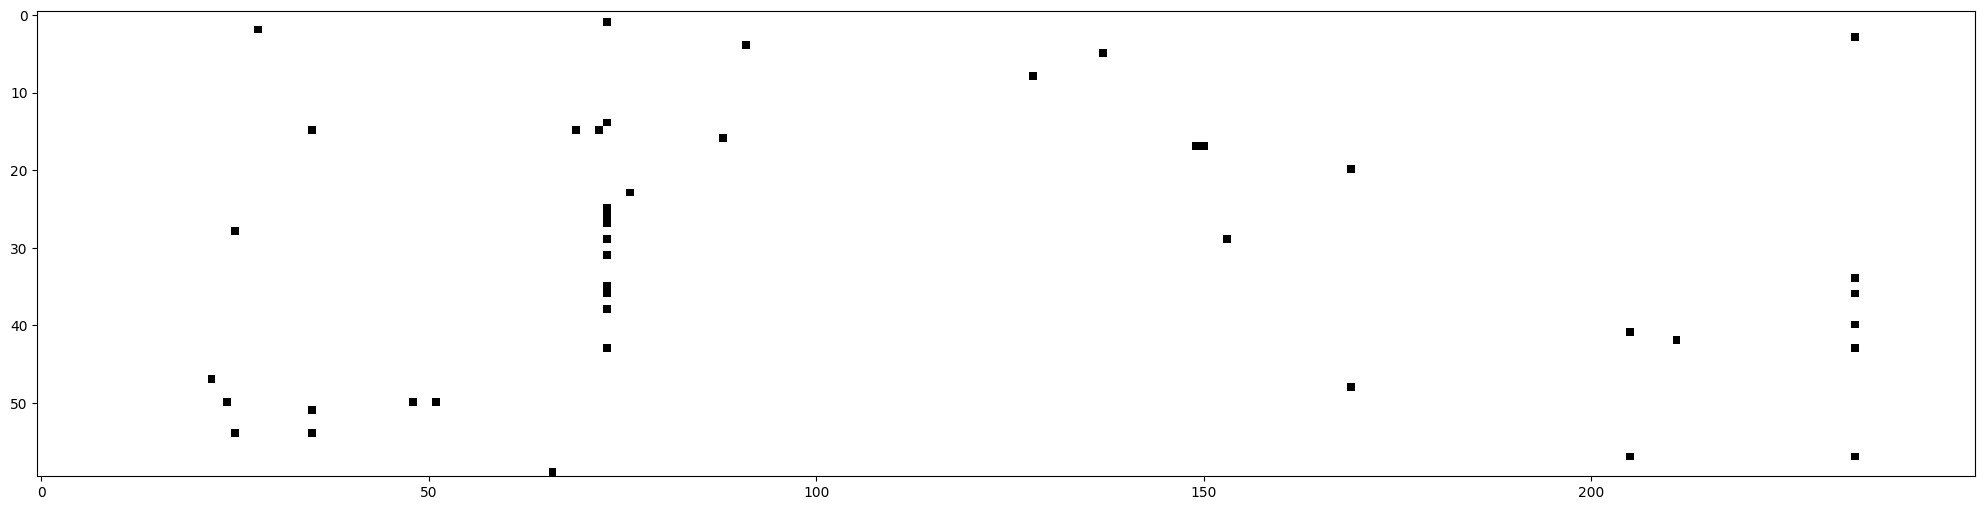

In [11]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');
#plt.grid()

In [12]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [13]:
#g_top_draw = Data(x=node_features, y=node_labels, edge_index=edge_index0)

def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
        
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

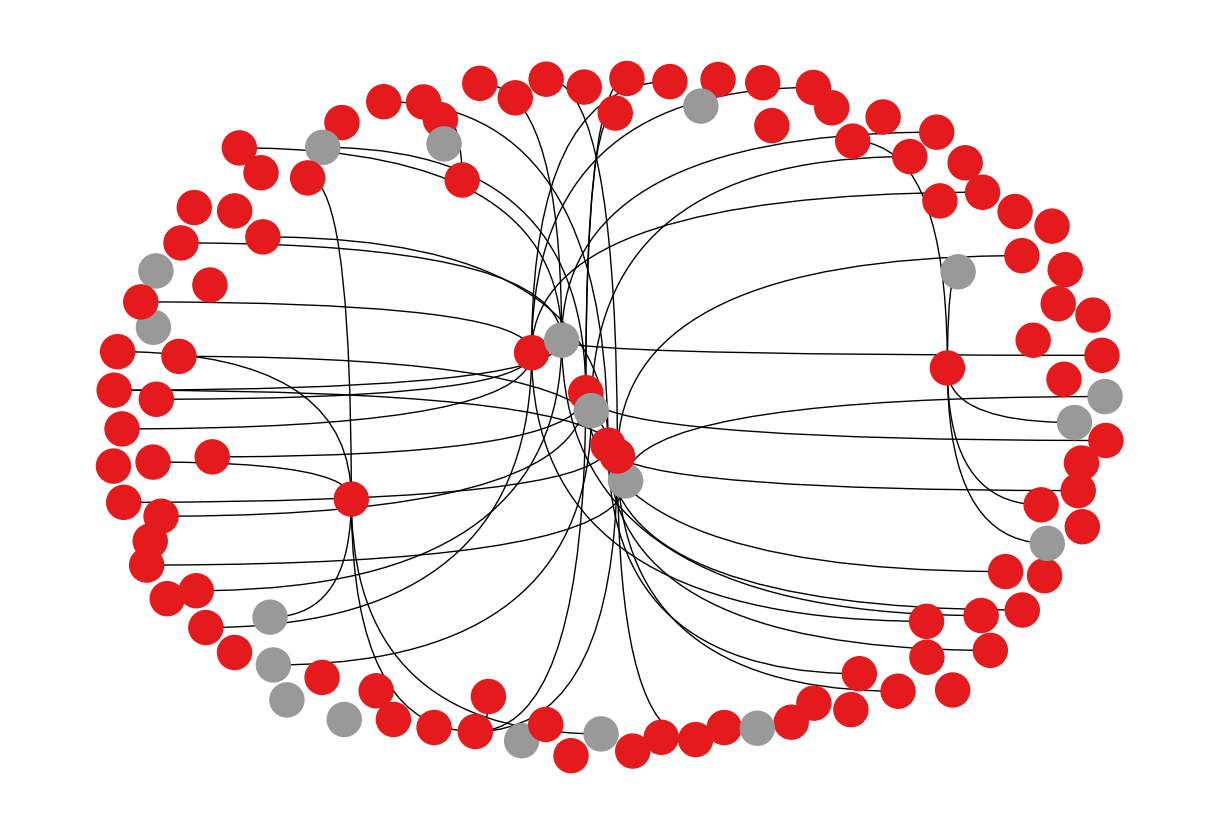

In [14]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)